<a href="https://colab.research.google.com/github/srkwon/analysis/blob/main/data_analysis_20250503.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from sklearn.datasets import fetch_openml


# 데이터 수집
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

x = x.values
y = y.astype(int).values



In [35]:
# 데이터 형태 파악(벡터)
x.shape, y.shape

x[:10]

# x.head()

# x.info()

x = ((x / 255.) - .5) * 2

print(type(x))


<class 'numpy.ndarray'>


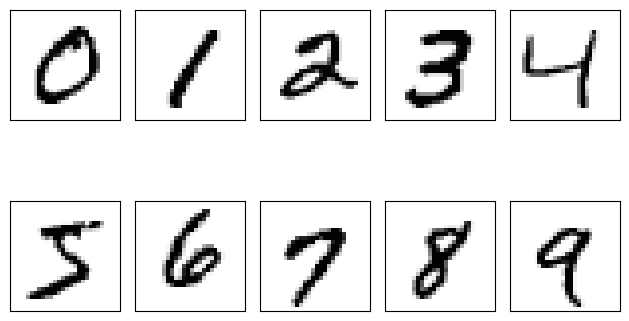

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(10):
    img = x[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

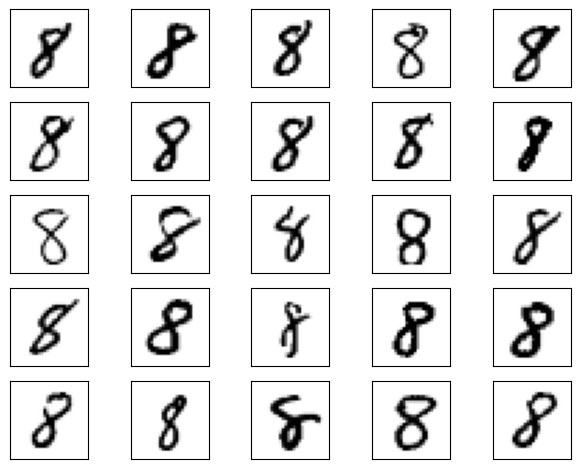

In [44]:
# 8에 해당하는 값만 여러개 출력해보기
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(25):
    img = x[y == 8][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [55]:
from sklearn.model_selection import train_test_split

# 테스트 데이터셋을 1만 건으로 정하고 나머지를 훈련 데이터셋으로 지정
# 훈련/검증/테스트로 나누니까, 일단 테스트를 분리해놓고 훈련 데이터셋을 훈련/검증으로 나누겠다는 것임
x_temp, x_test, y_temp, y_test = train_test_split(
    x, y,  test_size=10000, random_state=123, stratify=y
)

# 기존 훈련 데이터셋을 훈련/검증으로 구분
# 여기서 5만 건이 기존 테스트셋이고 5000건만 검증셋으로 구분하는 식으로 이용
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, y_temp,  test_size=5000, random_state=123, stratify=y_temp
)

# 훈련/검증/테스트 데이터셋 구성 체크
print(f"x_traiin={x_train.shape}, x_valid={x_valid.shape}, x_test={x_test.shape}")




x_traiin=(55000, 784), x_valid=(5000, 784), x_test=(10000, 784)


In [85]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    # print(f"shape={y.shape}, num_labels={num_labels}")
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

test = np.ones(3, dtype=int)

int_to_onehot(test, 3)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [78]:
# 코드 샘플 참고 https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.py#L233C1-L288C46

class SimpleMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123) -> None:
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden)
        )
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)





In [82]:
model = SimpleMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

model


(100, 784)
(100,)
Initial validation MSE: 0.0
Initial validation accuracy: 93.4%
Initial valid MSE: 0.0
Initial valid accuracy: 93.4%
Epoch: 001/050 | Train MSE: 0.01 | Train Acc: 93.81% | Valid Acc: 93.58%
Epoch: 002/050 | Train MSE: 0.01 | Train Acc: 93.87% | Valid Acc: 93.56%
Epoch: 003/050 | Train MSE: 0.01 | Train Acc: 93.99% | Valid Acc: 93.66%
Epoch: 004/050 | Train MSE: 0.01 | Train Acc: 94.09% | Valid Acc: 93.68%
Epoch: 005/050 | Train MSE: 0.01 | Train Acc: 94.20% | Valid Acc: 93.76%
Epoch: 006/050 | Train MSE: 0.01 | Train Acc: 94.25% | Valid Acc: 93.74%
Epoch: 007/050 | Train MSE: 0.01 | Train Acc: 94.35% | Valid Acc: 94.06%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 94.48% | Valid Acc: 94.02%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 94.54% | Valid Acc: 94.04%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 94.56% | Valid Acc: 94.14%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 94.67% | Valid Acc: 94.18%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 94.78% | Valid Ac

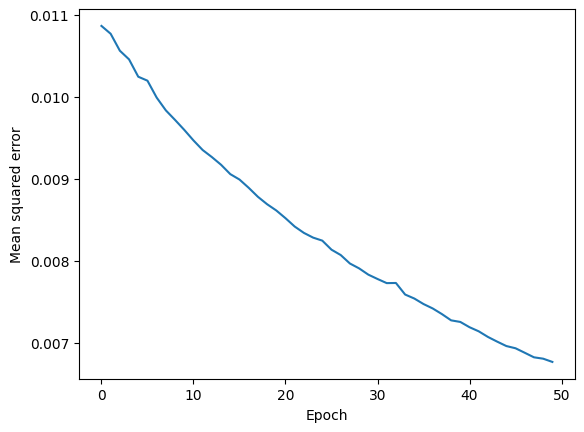

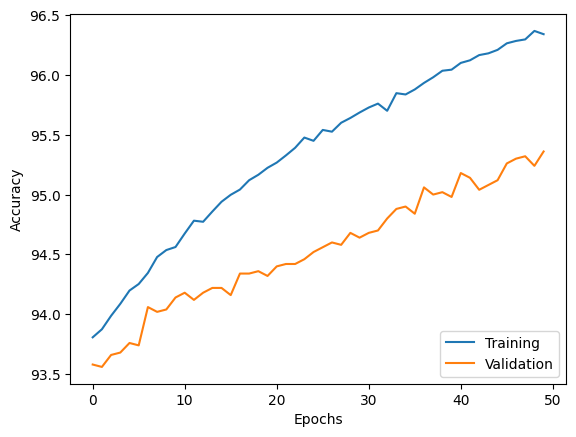

Test accuracy: 95.11%


In [86]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        x_train, y_train, minibatch_size)

    for x_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(x_train_mini.shape)
print(y_train_mini.shape)


# Defining a function to compute the loss and accuracy



def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(x_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')




def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc




mse, acc = compute_mse_and_acc(model, x_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')




def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h =                 model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc




np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, x_train, y_train, x_valid, y_valid,
    num_epochs=50, learning_rate=0.1)


# ## Evaluating the neural network performance



plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()




plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()




test_mse, test_acc = compute_mse_and_acc(model, x_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')


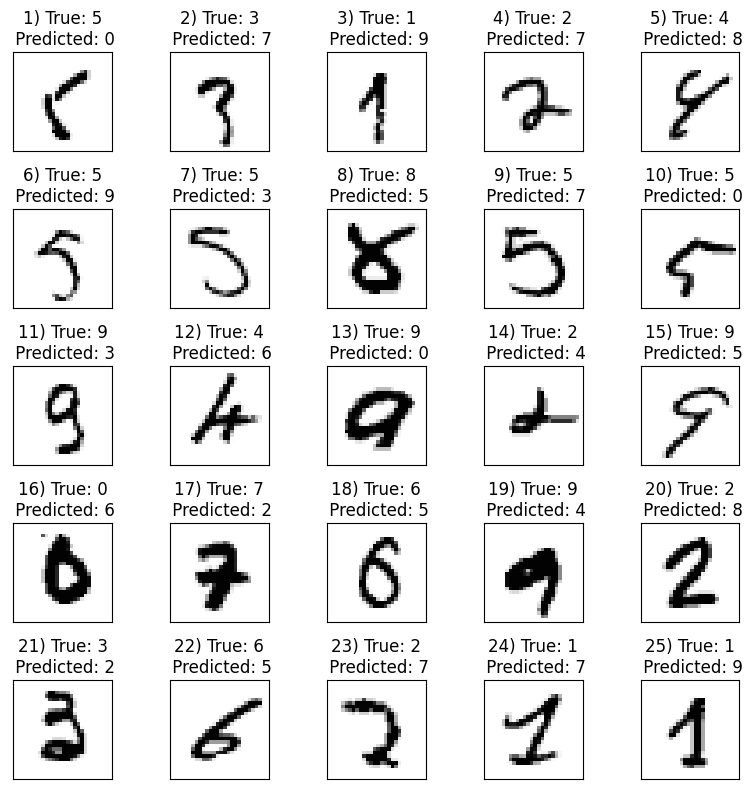

In [87]:


# Plot failure cases:



X_test_subset = x_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]




fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()


In [88]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 745.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli